GENERAL COMMENTS

* For this project I used inspiration from the following source which uses the SARIMAX model with exogeneous variables to forecast time-series
https://www.linkedin.com/pulse/time-series-episode-3-arima-forecasting-exogenous-vasilis-kalyvas-c09kf/

* The solution uses the 10 available data points (04-08 for 2010 and 04-08 for 2011) of each household to train a SARIMAX model and generate future predictions with confidence intervals.

* In this notebook I run the model only for one household (hh_id) as an example

* I used the 5 data points in 2010 for training and the 5 data points in 2011 for testing.




In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sb
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [25]:
file = "forecasting_test.csv"
df = pd.read_csv(file)
df.head()

,hh_id,year,month,zipcode,mozip,lusage,luse1,luse2,luse3,luse4,...,income2,income3,income4,income5,income6,income7,income8,income9,owner,size
0,3,2010,4,53.0,540.0,6.322805,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
1,3,2010,5,53.0,541.0,6.510683,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
2,3,2010,6,53.0,542.0,6.696693,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
3,3,2010,7,53.0,543.0,6.967286,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
4,3,2010,8,53.0,544.0,6.966908,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN


In [26]:
#small hack to assign datetime proper format
df['day'] = 1
datetime = pd.to_datetime(df[['year','month','day']], format='%Y.%m.%d')
df['date'] = datetime
df.index = datetime
df.head()

,hh_id,year,month,zipcode,mozip,lusage,luse1,luse2,luse3,luse4,...,income4,income5,income6,income7,income8,income9,owner,size,day,date
2010-04-01,3,2010,4,53.0,540.0,6.322805,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,2010-04-01
2010-05-01,3,2010,5,53.0,541.0,6.510683,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,2010-05-01
2010-06-01,3,2010,6,53.0,542.0,6.696693,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,2010-06-01
2010-07-01,3,2010,7,53.0,543.0,6.967286,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,2010-07-01
2010-08-01,3,2010,8,53.0,544.0,6.966908,6.505642,6.388161,6.207919,6.439571,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,2010-08-01


In [27]:
print(pd.unique(df['hh_id']))
#there are about 40k households in the dataset

[    3     4     5 ... 47354 47355 47356]


In [28]:
#HANDLE MISSING DATA

#Identify which variables are continuous and which ones are categorical
for col in df.columns:
    print(col)
    print(df[col].value_counts())

missing_data = df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

hh_id
hh_id
3        10
31539    10
31556    10
31555    10
31554    10
         ..
15759    10
15758    10
15757    10
15755    10
47356    10
Name: count, Length: 31824, dtype: int64
year
year
2010    159120
2011    159120
Name: count, dtype: int64
month
month
4    63648
5    63648
6    63648
7    63648
8    63648
Name: count, dtype: int64
zipcode
zipcode
42.0    45890
28.0    42170
15.0    34410
1.0     32160
57.0    27450
        ...  
9.0        10
45.0       10
73.0       10
66.0       10
7.0        10
Name: count, Length: 75, dtype: int64
mozip
mozip
426.0    4589
425.0    4589
427.0    4589
428.0    4589
429.0    4589
         ... 
762.0       1
84.0        1
710.0       1
711.0       1
75.0        1
Name: count, Length: 750, dtype: int64
lusage
lusage
5.631212    11
6.173786    11
6.324359    10
5.521461    10
5.886104    10
            ..
5.989962     1
6.314893     1
6.151898     1
6.790090     1
7.193545     1
Name: count, Length: 280279, dtype: int64
luse1
luse1
6.397243  

In [29]:
continuous = ['zipcode', 'mozip', 'luse1', 'luse2', 'luse3', 'luse4', 'luse5', 'luse6', 'size']
categorical = ['children', 'hhsize2',
       'hhsize3', 'hhsize4', 'hhsize5', 'hhsize5plus', 'income2', 'income3',
       'income4', 'income5', 'income6', 'income7', 'income8', 'income9',
       'owner']

#replace missing values in continuous variables with the mean of the column
for col in continuous:
    avg_col = df[col].astype('float').mean(axis=0)
    df[col] = df[col].replace(np.nan, avg_col)

#replace missing values in categorical variables with the most frequent value in the column
for col in categorical:
    most_freq_col = df[col].value_counts().idxmax()
    df[col] = df[col].replace(np.nan, most_freq_col)

In [40]:
def test_stationarity(timeseries):
    dftest_initial = adfuller(timeseries)
    dfoutput_initial = pd.Series(dftest_initial[0:4],
                                 index=['Statistical Test',
                                        'p-value',
                                        '#Lags used',
                                        'Number of observations'
                                        ])

    for key, value in dftest_initial[4].items():
        dfoutput_initial['Critical value ' + key] = value

    print(dfoutput_initial)

house_id = 5
df_c = df.loc[df['hh_id']==house_id]
print(df_c)

test_stationarity(df_c['lusage'])

#since the p-value is < 0.05 the time series is considered stationary so we can employ the SARIMAX model

            hh_id  year  month  zipcode  mozip    lusage     luse1     luse2  \
2010-04-01      5  2010      4     53.0  540.0  6.068280  5.501752  5.306729   
2010-05-01      5  2010      5     53.0  541.0  5.906671  5.501752  5.306729   
2010-06-01      5  2010      6     53.0  542.0  5.503161  5.501752  5.306729   
2010-07-01      5  2010      7     53.0  543.0  5.664536  5.501752  5.306729   
2010-08-01      5  2010      8     53.0  544.0  5.466142  5.501752  5.306729   
2011-04-01      5  2011      4     53.0  545.0  7.047365  5.501752  5.306729   
2011-05-01      5  2011      5     53.0  546.0  5.415426  5.501752  5.306729   
2011-06-01      5  2011      6     53.0  547.0  5.284096  5.501752  5.306729   
2011-07-01      5  2011      7     53.0  548.0  5.656390  5.501752  5.306729   
2011-08-01      5  2011      8     53.0  549.0  5.835523  5.501752  5.306729   

               luse3     luse4  ...  income4  income5  income6  income7  \
2010-04-01  5.079502  5.113806  ...      0.0

<ipython-input-41-267b0d623f9e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_09 = [df_c[i][0] for i in ['luse1', 'luse2', 'luse3', 'luse4', 'luse5', 'luse6']]


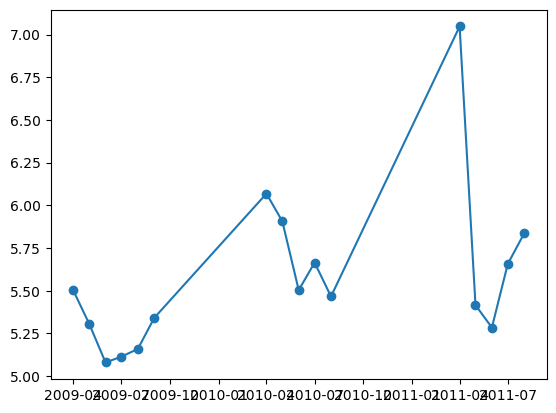

In [41]:
#Plot timeseries for the data points in 2010 (04-08) and 2011 (04-08) + ALSO the 2009 values (pre sample period) (04-09)
start = "04-01-2009"
end = "09-01-2009"
x_09 = pd.date_range(start, end, freq='MS')
y_09 = [df_c[i][0] for i in ['luse1', 'luse2', 'luse3', 'luse4', 'luse5', 'luse6']]

timeseries = x_09.to_list() + df_c['date'].to_list()
lusage =  y_09 + df_c['lusage'].to_list()

plt.scatter(timeseries, lusage)
plt.plot(timeseries, lusage)


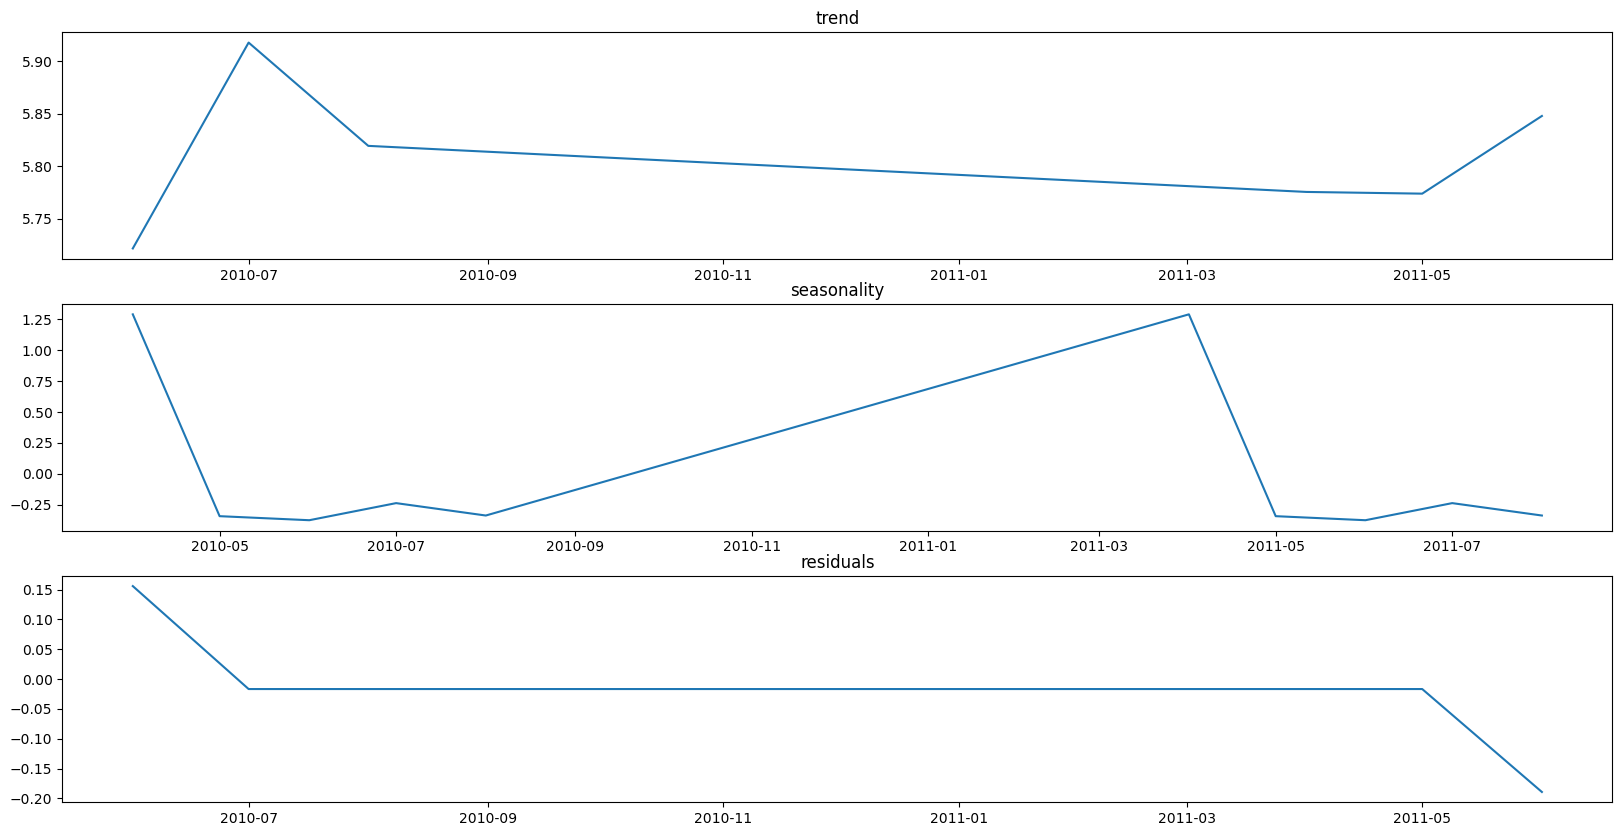

In [42]:
result_decompose = seasonal_decompose(df_c['lusage'], model='additive', period = 5)
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid

# plot every component
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(trend)
plt.title('trend')

plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')

plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')
plt.show()

#Plots show small trend but large seasonality

In [43]:
def test_stationarity(timeseries):
    dftest_initial = adfuller(timeseries)
    dfoutput_initial = pd.Series(dftest_initial[0:4],
                                 index=['Statistical Test',
                                        'p-value',
                                        '#Lags used',
                                        'Number of observations'
                                        ])

    for key, value in dftest_initial[4].items():
        dfoutput_initial['Critical value ' + key] = value

    print(dfoutput_initial)

house_id = 3 #pick first house as example to forecast
df_c = df.loc[df['hh_id']==house_id]
#print(df_c)

test_stationarity(df_c['lusage'])

#p-value < 0.05 so the series is considered stationary

Statistical Test         -3.218876
p-value                   0.018918
#Lags used                1.000000
Number of observations    8.000000
Critical value 1%        -4.665186
Critical value 5%        -3.367187
Critical value 10%       -2.802961
dtype: float64


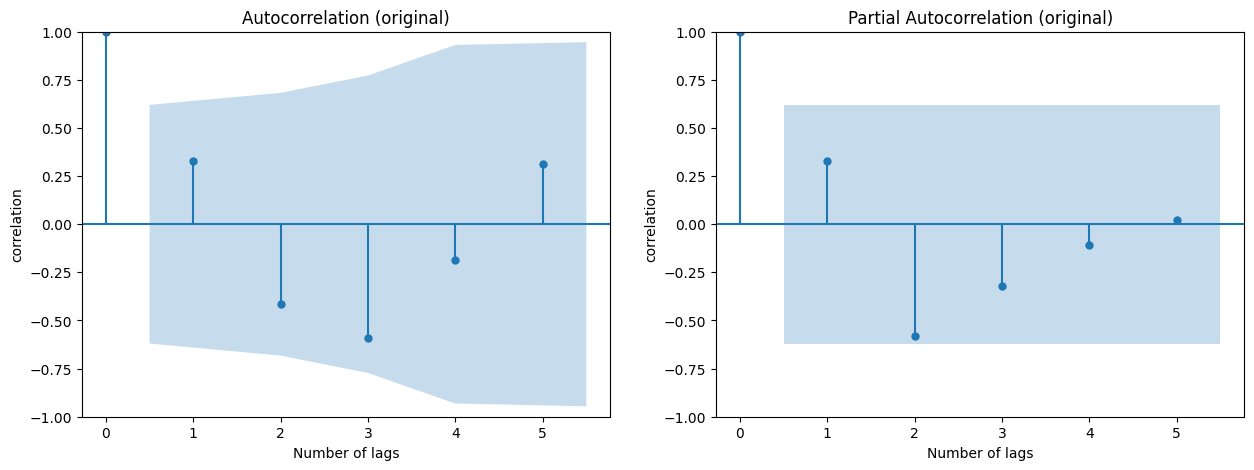

In [44]:
def autocorrelation_plots(timeseries, description, n_lags):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Partial Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.show()

autocorrelation_plots(df_c['lusage'],'original', 5)
#autocorrelation plots look fine

In [45]:
test_nr = 5
train = df_c[:-test_nr]
test = df_c[-test_nr:]
print('training set (past data): ', len(train))
print('test set (months to be forecasted ahead): ', len(test))

exog_var_train = train[['month','zipcode', 'mozip', 'size', 'children', 'hhsize2',
       'hhsize3', 'hhsize4', 'hhsize5', 'hhsize5plus', 'income2', 'income3',
       'income4', 'income5', 'income6', 'income7', 'income8', 'income9',
       'owner', 'luse1','luse2','luse3','luse4','luse5','luse6' ]]
exog_var_test  = test[['month','zipcode', 'mozip', 'size', 'children', 'hhsize2',
       'hhsize3', 'hhsize4', 'hhsize5', 'hhsize5plus', 'income2', 'income3',
       'income4', 'income5', 'income6', 'income7', 'income8', 'income9',
       'owner', 'luse1','luse2','luse3','luse4','luse5','luse6']]


training set (past data):  5
test set (months to be forecasted ahead):  5


/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                            lusage   No. Observations:                    5
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 5)   Log Likelihood                   7.800
Date:                           Fri, 30 Aug 2024   AIC                             40.401
Time:                                   16:34:52   BIC                             29.465
Sample:                               04-01-2010   HQIC                            11.050
                                    - 08-01-2010                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month           0.0874      0.021      4.084      0.000       0.045       0.129
zipcode     -3.903e-05   1.11e-05     -3

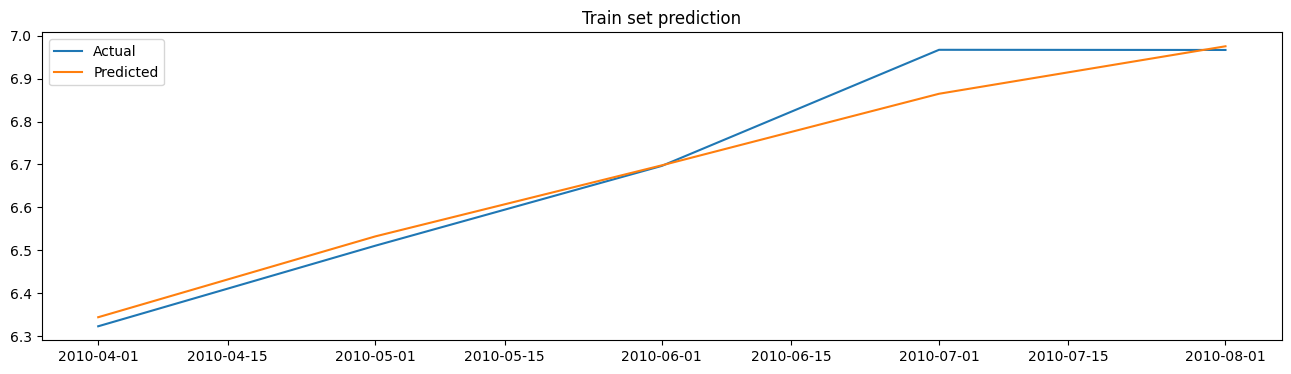

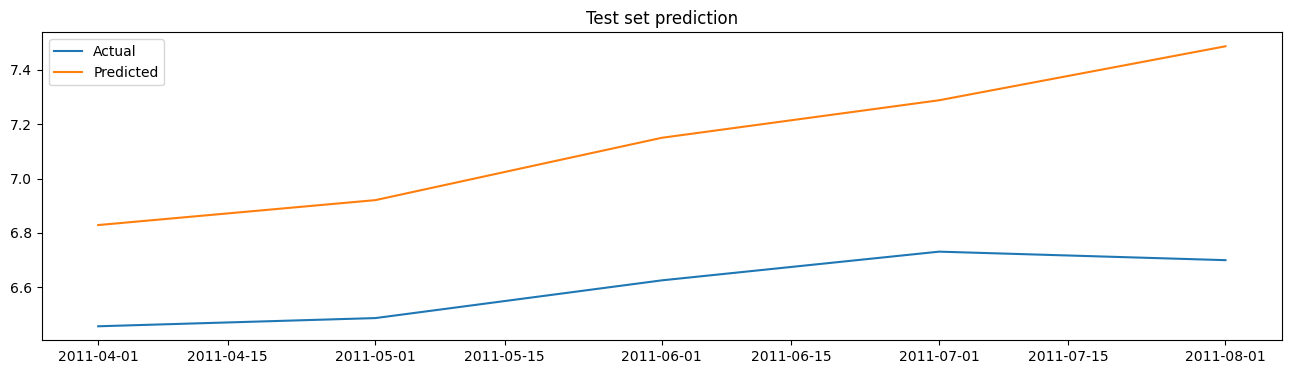

In [46]:
# create and fit the model
model_fit = SARIMAX(train['lusage'],order = (1,0,0), seasonal_order = (1,0,0,5),exog = exog_var_train).fit(disp=False)

print(model_fit.summary())
print('\n')

#####################################################################################

# create forecasts on training set (to evaluate how the model behaves to known-training data)
forecasts_on_train = model_fit.predict()

# create forecasts on test set (to evaluate how the model behaves to unknown-test data)
#forecasts_on_test  = model_fit.forecast(len(test), exog = exog_var_test)

forecasts_on_test  = model_fit.predict(start = 5, end = 9, exog = exog_var_test)
forecasts_on_test.index = forecasts_on_test.index + pd.DateOffset(months = 7)

RMSE = np.sqrt(mean_squared_error(test['lusage'], forecasts_on_test))

# print the AIC and RMSE
print('AIC: ' , model_fit.aic)
print('RMSE: ', RMSE)


#####################################################################################


# plot the train and test data against their corresponding forecasts

# on train data
plt.figure(figsize=(16,4))
plt.title("Train set prediction")
plt.plot(train['lusage'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.title("Test set prediction")
plt.plot(test['lusage'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

plt.show()

<ipython-input-54-8d3b1caa82b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_var_pred['mozip'] = exog_var_test['mozip'] + 5


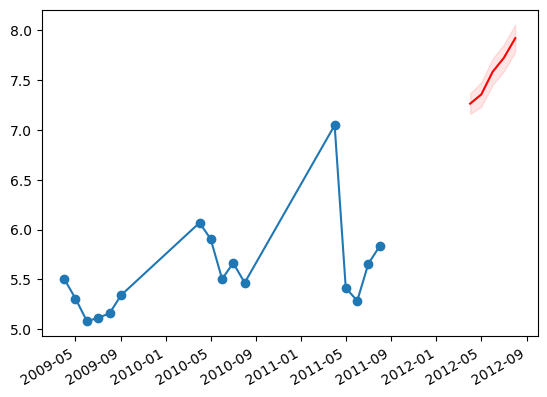

In [54]:
exog_var_pred = exog_var_test
# mozip is the only variable that is time-dependant and
#it seems it grows linearly with time so i assign it manually for the set of exogeneous variables used for future prediction
exog_var_pred['mozip'] = exog_var_test['mozip'] + 5   

future_pred = model_fit.get_forecast(steps = 5, exog = exog_var_pred).summary_frame(alpha=0.05)
future_pred.index = future_pred.index + pd.DateOffset(months = 19)
future_pred
#this is the prediction for the next 5 months with confidence intervals


plt.scatter(timeseries, lusage)
plt.plot(timeseries, lusage )

future_pred['mean'].plot(style='r', label='Predicted Mean')
plt.fill_between(
    future_pred.index, future_pred['mean_ci_lower'], future_pred['mean_ci_upper'],
    color='r', alpha=0.1
)

